# Jupyter Notebook demonstrating Welday _et al._ (2011)
[Cosine Directional Tuning of Theta Cell Burst Frequencies: Evidence for Spatial Coding by Oscillatory Interference](http://www.jneurosci.org/content/31/45/16157.long)

In [1]:
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
import math

import vco

%matplotlib inline

## VCO Matrix and DBFT curves
We establish and initialize the VCO matrix shown in Figure 7. We then show various tuning curves, which are analogous to the directional burst frequency-tuning (DBFT) curves shown in Figures 1-6, 8. 

First, we'll initialize the 6-by-12 VCO matrix from Figure 7:

In [2]:
N = 12
numrow = 6; numcol = 12;

rhos = 0.14 * (np.sqrt(3) ** np.arange(numrow))
thetas = np.pi + 2.0*np.pi*(np.arange(numcol))/numcol


VCOmatrix = [[vco.VCO_model(N, rhos[i], thetas[j]) for j in range(numcol)] for i in range(numrow)]

Then, we create a velocity vector (path) to serve as input to the VCOs:

In [3]:
# Create a simulated running path (constant velocity, running around in a circle)
d = np.arange(0, 2 * np.pi, 0.001)
v = 2*np.ones_like(d)
pol_path = np.asarray([v,d]).T
x = v * np.cos(d)
y = v * np.sin(d)

Then, we calculate and plot the tuning curves (analogous to DBFT curves) for each cell in the "first" VCO (i.e. $[\rho,\theta] = [0.14,\pi]$).

In [4]:
# Create tuning curves by calculating angular frequency
tune = np.zeros((d.shape[0],N))
for cell in range(N):
    tune[:,cell] = VCOmatrix[0][0].get_angular_freq(cell, pol_path)

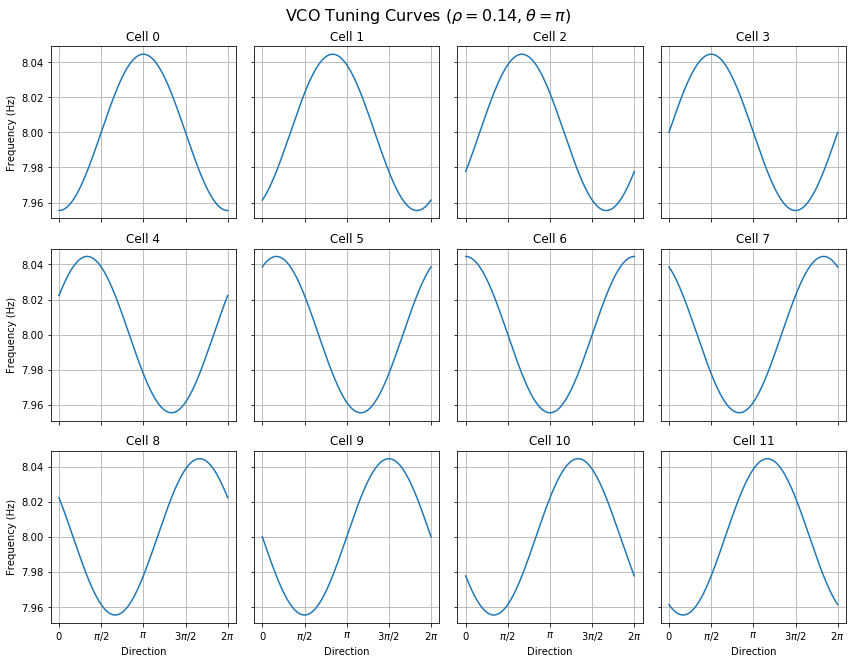

In [5]:
# Plot the tuning curves
fig, axs = plt.subplots(3,4,sharex=True,sharey=True,figsize=(12,9))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for cell in range(N):
    axs[cell].plot(d,tune[:,cell])
    axs[cell].set_title('Cell %d' % cell)
    axs[cell].grid()
    
    if not (cell) % 4:
        axs[cell].set_ylabel('Frequency (Hz)')
    if cell >= 8:
        axs[cell].set_xlabel('Direction')
        axs[cell].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
        axs[cell].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"]);

plt.tight_layout()
plt.suptitle(r"VCO Tuning Curves ($\rho = 0.14, \theta = \pi$)",fontsize=16,y=1.02);

We can also visualize the activity of the entire VCO at a particular timestep to see how the module acts as a bump attractor (like the head-direction cell on which it is based):

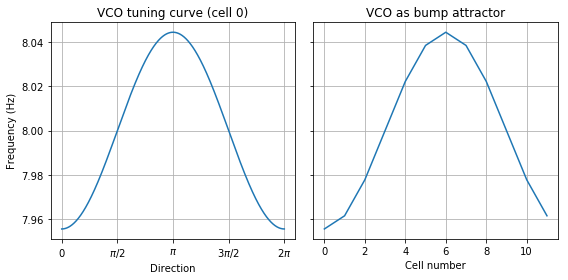

In [6]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(8,4))
axs[0].set_title('VCO tuning curve (cell 0)')
axs[0].plot(pol_path[:,1], tune[:,0])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Direction')
axs[0].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
axs[0].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"])
axs[0].grid()

axs[1].set_title('VCO as bump attractor')
axs[1].plot(np.arange(N),tune[0,:])
axs[1].set_xlabel('Cell number')
axs[1].grid()

plt.tight_layout()

## Forming Hippocampal Nav. Cells from VCOs

Now, using the matrix from Figure 7 defined above, we can demonstrate all of the cells shown in the paper and supplemental material (Figures 7 and 9). The weight matrices plotted here correspond in organization to that in Figure 7. By creating 2D random walks, we can also show the response of a cell over a realistic path, rather than only the ideal response over the entire arena.

In [33]:
size = 5

Define weight matrices for all the example cells from the paper:

In [8]:
# border cell (Fig. 7)
weights_border = np.full([6,12],np.nan)
weights_border[:,9] = [2,3,5,7,11,9]

# large grid (Fig. 7)
weights_lgrid = np.full([6,12],np.nan)
weights_lgrid[3,0] = 9
weights_lgrid[3,4] = 9
weights_lgrid[3,8] = 3

# small grid (Fig. 7)
weights_sgrid = np.full([6,12],np.nan)
weights_sgrid[3,1] = 1
weights_sgrid[3,5] = 9
weights_sgrid[3,9] = 3

# place cell (Fig. 7)
weights_place = np.full([6,12],np.nan)
rot_place = 8*np.pi/6. #orientation of the tuning function is zero by default
weights_place[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
weights_place[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
weights_place[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]

# curved border (Fig. 9)
weights_cborder = np.full([6,12],np.nan)
for col in [0,1,2,3,4,11]:
    weights_cborder[:,col] = [1,1,2,4,7,1]
    
#lumpy border (supplemental)
weights_lborder = np.full([6,12],np.nan)
weights_lborder[:,0] = [1,2,3,5,8,3]
weights_lborder[2,2] = 6
weights_lborder[3,2] = 1

# multi-field dentate place cell in square box (supplemental)
weights_dplace = np.full([6,12],np.nan)
weights_dplace[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
weights_dplace[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
weights_dplace[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

Calculate all envelopes and norms:

In [46]:
border_norm, border_env = vco.matrix_sum(VCOmatrix, weights_border,  size)
lgrid_norm, lgrid_env   = vco.matrix_sum(VCOmatrix, weights_lgrid,   size)
sgrid_norm, sgrid_env   = vco.matrix_sum(VCOmatrix, weights_sgrid,   size)
place_norm, place_env   = vco.matrix_sum(VCOmatrix, weights_place,   size)
cbord_norm, cbord_env   = vco.matrix_sum(VCOmatrix, weights_cborder, size)
lbord_norm, lbord_env   = vco.matrix_sum(VCOmatrix, weights_lborder, size)
dplace_norm, dplace_env = vco.matrix_sum(VCOmatrix, weights_dplace,  size)

Plotting all envelopes and norms:

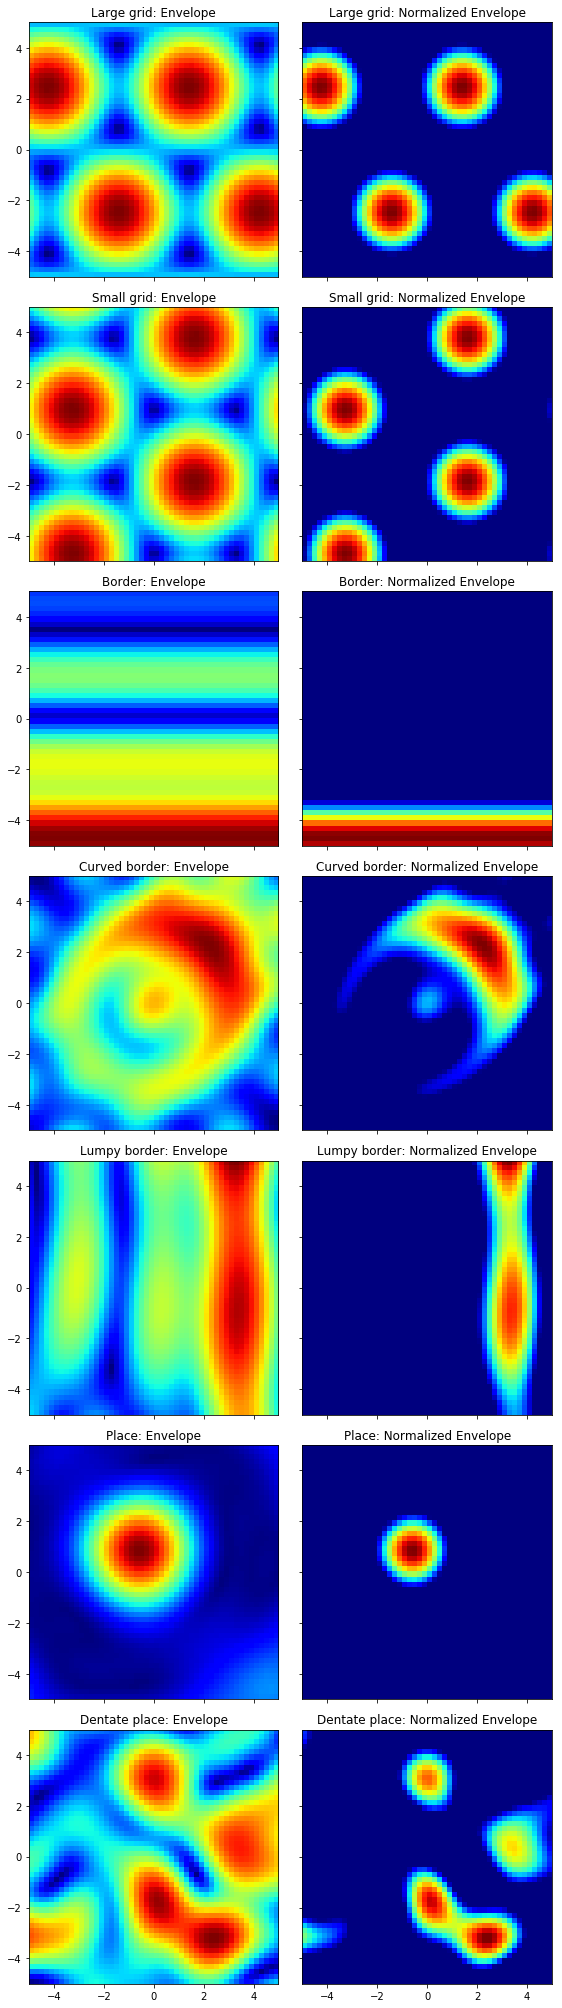

In [65]:
fig, axs = plt.subplots(7,2,sharex=True,sharey=True,figsize=(8,28))

axs[0][0].imshow(lgrid_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[0][0].set_title('Large grid: Envelope')
axs[0][1].imshow(lgrid_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[0][1].set_title('Large grid: Normalized Envelope')

axs[1][0].imshow(sgrid_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[1][0].set_title('Small grid: Envelope')
axs[1][1].imshow(sgrid_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[1][1].set_title('Small grid: Normalized Envelope')

axs[2][0].imshow(border_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[2][0].set_title('Border: Envelope')
axs[2][1].imshow(border_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[2][1].set_title('Border: Normalized Envelope')

axs[3][0].imshow(cbord_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[3][0].set_title('Curved border: Envelope')
axs[3][1].imshow(cbord_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[3][1].set_title('Curved border: Normalized Envelope')

axs[4][0].imshow(lbord_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[4][0].set_title('Lumpy border: Envelope')
axs[4][1].imshow(lbord_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[4][1].set_title('Lumpy border: Normalized Envelope')

axs[5][0].imshow(place_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[5][0].set_title('Place: Envelope')
axs[5][1].imshow(place_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[5][1].set_title('Place: Normalized Envelope')

axs[6][0].imshow(dplace_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[6][0].set_title('Dentate place: Envelope')
axs[6][1].imshow(dplace_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[6][1].set_title('Dentate place: Normalized Envelope')

plt.tight_layout()

Create a random walk to plot:

In [66]:
N=75000
path = vco.randwalk(5,N,2*size)

Plot all seven random walks:

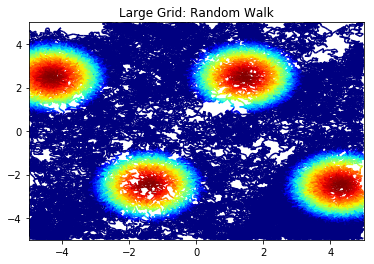

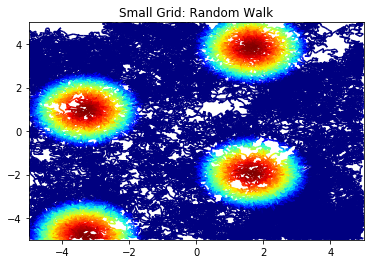

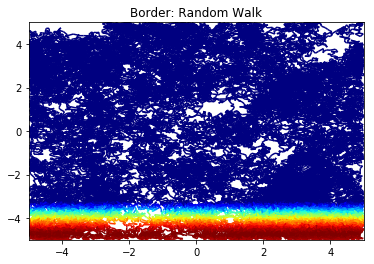

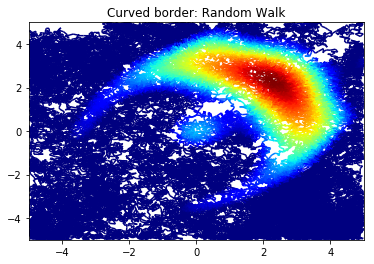

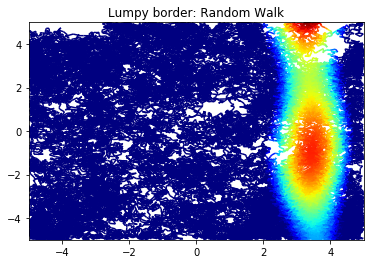

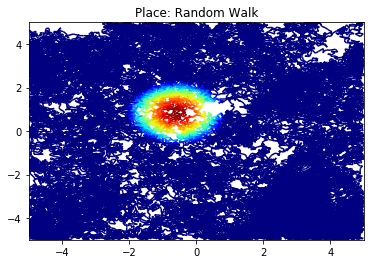

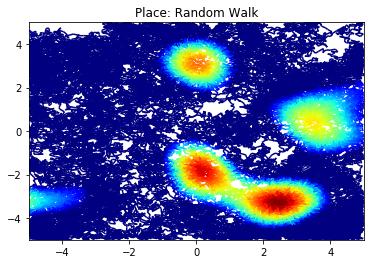

In [72]:
vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_lgrid, path))
plt.title('Large Grid: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_sgrid, path))
plt.title('Small Grid: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_border, path))
plt.title('Border: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_cborder, path))
plt.title('Curved border: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_lborder, path))
plt.title('Lumpy border: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_place, path))
plt.title('Place: Random Walk');

vco.plot_randwalk(path, vco.matrix_sum_rw(VCOmatrix, weights_dplace, path))
plt.title('Place: Random Walk');

## Extending Welday _et al._ (2011)
### Adding Noise to intra-VCO Timing
The first extension we make to the Welday model is adding noise to the phase shift between each of the $N$ cells in a single ring oscillator VCO. As described in `vco.py` and `vco_demo.ipynb`, the noise added may either be described by a uniform or gaussian distribution. In this notebook, we demonstrate the addition of uniform noise.

In [85]:
N = 12
rho = 0.14
theta = 0
noiseless = 0
noisy = 1
VCO_reg = vco.VCO_model(N, rho, theta, noiseless)
VCO_jitter = vco.VCO_model(N, rho, theta, noisy)

In [86]:
tune_noiseless = np.zeros((d.shape[0],N))
for cell in range(N):
    tune_noiseless[:,cell] = VCO_reg.get_angular_freq(cell, pol_path)
    
tune_noisy = np.zeros((d.shape[0],N))
for cell in range(N):
    tune_noisy[:,cell] = VCO_jitter.get_angular_freq(cell, pol_path)

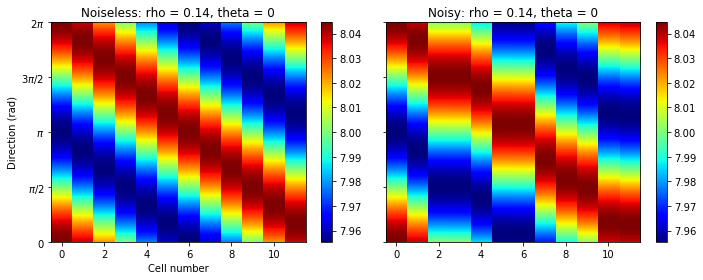

In [130]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

im0 = axs[0].imshow(tune_noiseless, aspect='auto',cmap='jet',origin='lower')
axs[0].set_title('Noiseless: rho = 0.14, theta = 0')
axs[0].set_ylabel('Direction (rad)')
axs[0].set_yticks([0., .5*np.pi*1000, np.pi*1000, 1.5*np.pi*1000, 2*np.pi*1000])
axs[0].set_yticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"])
axs[0].set_xlabel('Cell number')

im1 = axs[1].imshow(tune_noisy, aspect='auto',cmap='jet',origin='lower')
axs[1].set_title('Noisy: rho = 0.14, theta = 0')

fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()

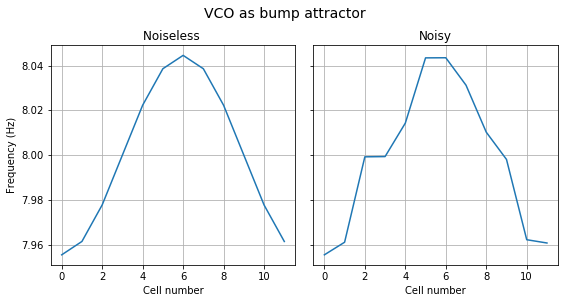

In [131]:
fig, axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(8,4))
axs[0].set_title('Noiseless ')
axs[0].plot(np.arange(N), tune_noiseless[int(tune_noiseless.shape[0]/2),:])
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Cell number')
axs[0].grid()

axs[1].set_title('Noisy')
axs[1].plot(np.arange(N),tune_noisy[int(tune_noisy.shape[0]/2),:])
axs[1].set_xlabel('Cell number')
axs[1].grid()

plt.suptitle('VCO as bump attractor', y=1.04, fontsize=14)
plt.tight_layout()

### HC Nav Cells with intra-VCO Noise
We can still use these noisy VCOs to build hippocampal navigation cells. By choosing the `weights_choice` variable below, you can see any of the 7 cells plotted above constructed using a noisy VCO matrix.

In [132]:
jitter=np.pi/6

VCOmatrix_noisy = [[vco.VCO_model(N, rhos[i], thetas[j], jitter) for j in range(numcol)] for i in range(numrow)]

In [133]:
weights_choice = 6

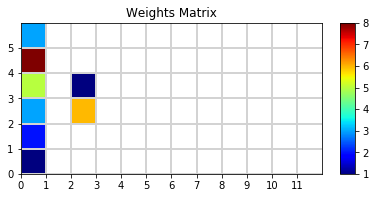

In [134]:
weights_noisy = np.full([6,12],np.nan)

# border cell
if weights_choice == 1:
    weights_noisy[:,9] = [2,3,5,7,11,9]
# large grid
elif weights_choice == 2:
    weights_noisy[3,0] = 9; weights_noisy[3,4] = 9; weights_noisy[3,8] = 3
#small grid
elif weights_choice == 3:
    weights_noisy[3,1] = 1; weights_noisy[3,5] = 9; weights_noisy[3,9] = 3
#place cell
elif weights_choice == 4:
    rotation_angle = 8*np.pi/6. #orientation of the tuning function is zero by default
    weights_noisy[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
    weights_noisy[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
    weights_noisy[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]
#curved border
elif weights_choice == 5:
    for col in [0,1,2,3,4,11]:
        weights_noisy[:,col] = [1,1,2,4,7,1]
#lumpy border
elif weights_choice == 6:
    weights_noisy[:,0] = [1,2,3,5,8,3]
    weights_noisy[2,2] = 6; weights_noisy[3,2] = 1
# multi-field dentate place cell in square box
elif weights_choice == 7:
    weights_noisy[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
    weights_noisy[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
    weights_noisy[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

# Plot weights matrix
vco.plot_weights(weights_noisy)

In [135]:
noiseless_norm, noiseless_env = vco.matrix_sum(VCOmatrix, weights_noisy, size)
noisy_norm, noisy_env = vco.matrix_sum(VCOmatrix_noisy, weights_noisy, size)

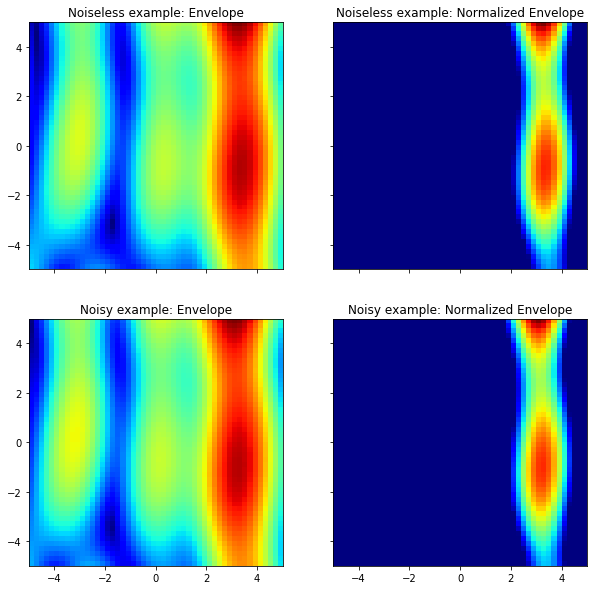

In [136]:
fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))

axs[0][0].imshow(noiseless_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[0][0].set_title('Noiseless example: Envelope')
axs[0][1].imshow(noiseless_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[0][1].set_title('Noiseless example: Normalized Envelope')

axs[1][0].imshow(noisy_env, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[1][0].set_title('Noisy example: Envelope')
axs[1][1].imshow(noisy_norm, aspect='auto', cmap='jet', extent=(-size,size,-size,size))
axs[1][1].set_title('Noisy example: Normalized Envelope')